In [1]:
!pip install folium

Defaulting to user installation because normal site-packages is not writeable


Loaded dataset: (9551, 21)
Saved heatmap map


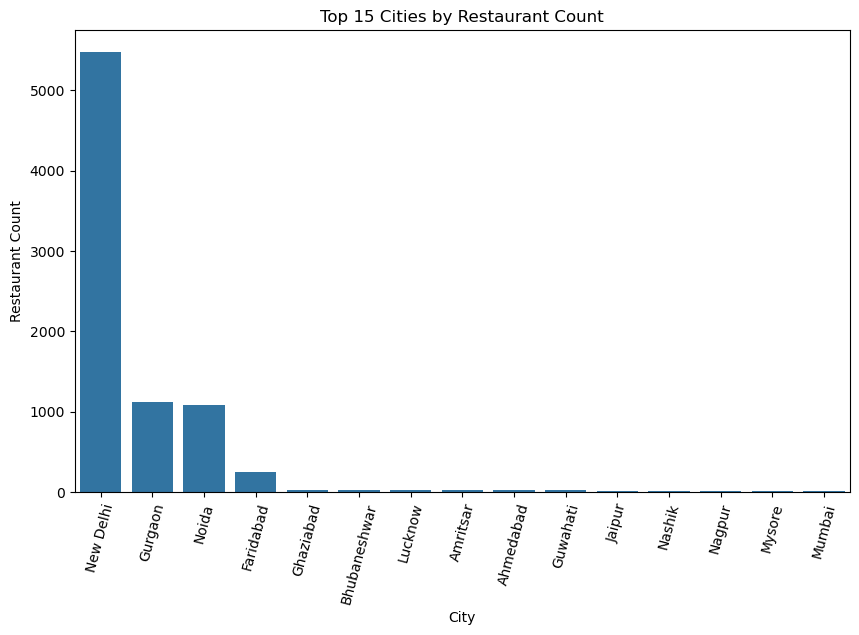

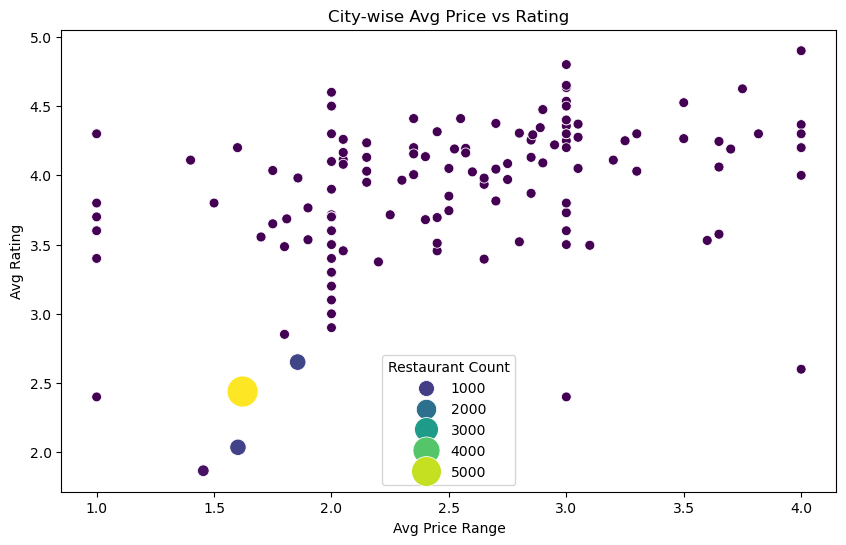

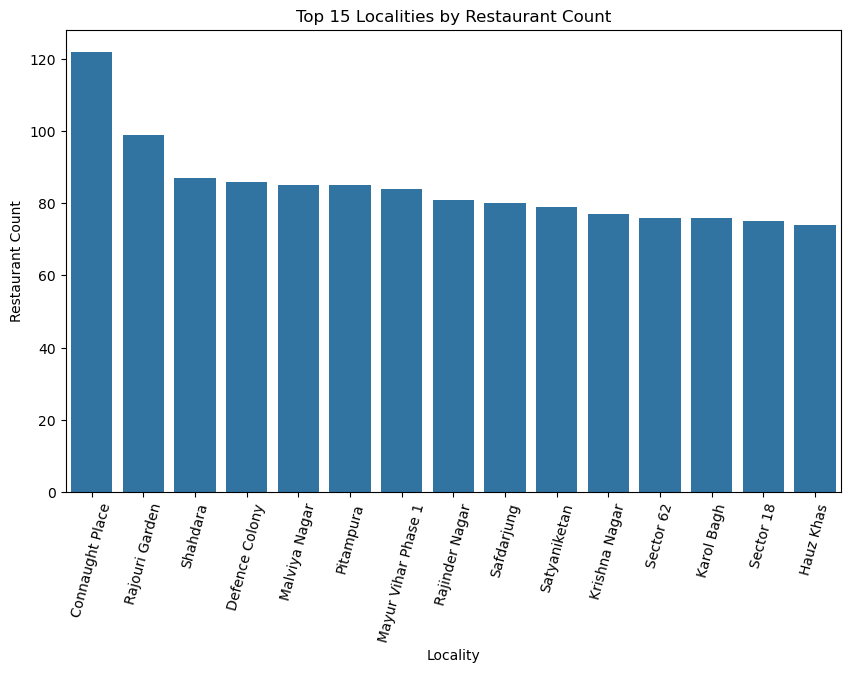

Insights saved: {'city_most_restaurants': {'City': 'New Delhi', 'Count': 5473}, 'highest_avg_rating_city': 'Inner City', 'highest_avg_price_city': 'Johannesburg'}


In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping libraries
import folium
from folium.plugins import HeatMap

# --- Config ---
CSV_PATH = "Dataset .csv"
OUTPUT_DIR = "outputs/location_analysis"
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Load ---
df = pd.read_csv(CSV_PATH)
print(f"Loaded dataset: {df.shape}")

# --- Ensure lat/lon available ---
lat_col = None
lon_col = None
for c in df.columns:
    if "lat" in c.lower():
        lat_col = c
    if "lon" in c.lower() or "lng" in c.lower():
        lon_col = c
if not lat_col or not lon_col:
    raise ValueError("Dataset missing latitude/longitude columns.")

# Clean
coords = df[[lat_col, lon_col]].dropna()

# --- Distribution Heatmap ---
map_center = [coords[lat_col].mean(), coords[lon_col].mean()]
m = folium.Map(location=map_center, zoom_start=11)
HeatMap(coords.values.tolist(), radius=8, blur=6).add_to(m)
m.save(os.path.join(OUTPUT_DIR, "restaurants_heatmap.html"))
print("Saved heatmap map")

# --- Group by City ---
if 'City' in df.columns:
    city_group = df.groupby('City').agg({
        'Restaurant Name':'count',
        'Aggregate rating':'mean',
        'Price range':'mean'
    }).rename(columns={'Restaurant Name':'Restaurant Count','Aggregate rating':'Avg Rating','Price range':'Avg Price Range'}).reset_index()
    city_group.sort_values('Restaurant Count', ascending=False, inplace=True)

    plt.figure(figsize=(10,6))
    sns.barplot(data=city_group.head(15), x='City', y='Restaurant Count')
    plt.xticks(rotation=75)
    plt.title('Top 15 Cities by Restaurant Count')
    plt.savefig(os.path.join(OUTPUT_DIR,'top_cities_restaurants.png'))
    plt.show()

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=city_group, x='Avg Price Range', y='Avg Rating', size='Restaurant Count', hue='Restaurant Count', sizes=(50,500), palette='viridis')
    plt.title('City-wise Avg Price vs Rating')
    plt.savefig(os.path.join(OUTPUT_DIR,'city_price_rating.png'))
    plt.show()

# --- Group by Locality (if available) ---
if 'Locality' in df.columns:
    loc_group = df.groupby('Locality').agg({
        'Restaurant Name':'count',
        'Aggregate rating':'mean',
        'Price range':'mean'
    }).rename(columns={'Restaurant Name':'Restaurant Count','Aggregate rating':'Avg Rating','Price range':'Avg Price Range'}).reset_index()
    loc_group.sort_values('Restaurant Count', ascending=False, inplace=True)

    plt.figure(figsize=(10,6))
    sns.barplot(data=loc_group.head(15), x='Locality', y='Restaurant Count')
    plt.xticks(rotation=75)
    plt.title('Top 15 Localities by Restaurant Count')
    plt.savefig(os.path.join(OUTPUT_DIR,'top_localities_restaurants.png'))
    plt.show()

# --- Cuisine distribution by City ---
if 'Cuisines' in df.columns and 'City' in df.columns:
    cuisine_counts = df.groupby('City')['Cuisines'].apply(lambda x: ','.join(x.dropna().astype(str))).apply(lambda s: s.split(','))
    cuisine_counts = cuisine_counts.apply(lambda lst: [c.strip() for c in lst])
    cuisine_top = cuisine_counts.apply(lambda lst: pd.Series(lst).value_counts().head(3).index.tolist())
    cuisine_summary = pd.DataFrame({
        'City': cuisine_top.index,
        'Top Cuisines': cuisine_top.values
    })
    cuisine_summary.to_csv(os.path.join(OUTPUT_DIR,'top_cuisines_by_city.csv'), index=False)

# --- Insights ---
insights = {}
if 'City' in df.columns:
    max_city = city_group.iloc[0]
    insights['city_most_restaurants'] = {
        'City': max_city['City'],
        'Count': int(max_city['Restaurant Count'])
    }
    insights['highest_avg_rating_city'] = city_group.loc[city_group['Avg Rating'].idxmax(), 'City']
    insights['highest_avg_price_city'] = city_group.loc[city_group['Avg Price Range'].idxmax(), 'City']

with open(os.path.join(OUTPUT_DIR,'insights.json'),'w') as f:
    json.dump(insights,f,indent=2)

print("Insights saved:", insights)